In [1]:
from quaternions import *
from networks import *
from sim_helpers import *
from liegroups.numpy import SO3
import torch
from convex_layers import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [2]:
path = 'saved_data/synthetic/synthetic_wahba_experiment_12-10-2019-17-17-32.pt'
checkpoint = torch.load(path)
args = checkpoint['args']
A_net = ANet(num_pts=args.matches_per_sample, bidirectional=args.bidirectional_loss).double()
model = QuatNet(A_net=A_net)
print('Loading data...')
model.load_state_dict(checkpoint['model_rep'], strict=False)
print('Done')

Loading data...
Done


In [3]:
train_data, test_data = create_experimental_data(100, 1000, args.matches_per_sample, sigma=args.sim_sigma)

In [4]:
def l2_diff(a, b):
    return (a - b).norm(dim=1)
def acos_diff(a, b):
    return (180./3.1415)*torch.acos((a*b).sum(dim=1, keepdim=True)).squeeze()

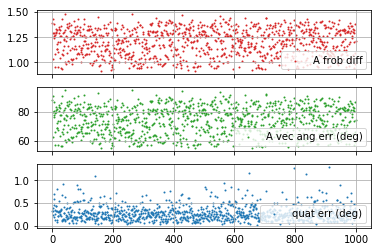

In [5]:
def _scatter(ax, x, y, title, color='tab:red'):
    ax.scatter(x, y, color=color, s=1, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return

model.eval()
i = torch.arange(0,test_data.x.shape[0])
with torch.no_grad():
    A_pred = model.A_net.forward(test_data.x[i])
    q_est = model.forward(test_data.x[i]).squeeze()
    
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row')
_scatter(ax[0], i, l2_diff(A_pred, convert_A_to_Avec(test_data.A_prior[i])).numpy(), 'A frob diff', color='tab:red')
_scatter(ax[1], i, acos_diff(A_pred, convert_A_to_Avec(test_data.A_prior[i])).numpy(), 'A vec ang err (deg)',color='tab:green')
_scatter(ax[2], i, quat_angle_diff(q_est, test_data.q[i], reduce=False).numpy(), 'quat err (deg)', color='tab:blue')
plt.show()

In [54]:
el, ev = np.linalg.eig(convert_Avec_to_A(A_pred[0]).numpy())
print(convert_Avec_to_A(A_pred[0]))
print(el)
print(ev)
print(q_est[0])


tensor([[-0.2935, -0.0525, -0.0810,  0.2206],
        [-0.0525, -0.1330,  0.2720,  0.2960],
        [-0.0810,  0.2720, -0.1677, -0.7807],
        [ 0.2206,  0.2960, -0.7807, -0.1977]], dtype=torch.float64)
[-1.14175939  0.64645984 -0.32643576  0.02989373]
[[-0.13691966 -0.22135711 -0.9647315  -0.03933417]
 [-0.37275917 -0.00993204  0.01735797  0.92771259]
 [ 0.62863339  0.68457676 -0.25708813  0.26472706]
 [ 0.66867307 -0.6944473   0.05382873  0.26023403]]
tensor([-0.1369, -0.3728,  0.6286,  0.6687], dtype=torch.float64)


In [53]:
A = test_data.A_prior[42].clone()
A = A/A.norm()
el, ev = np.linalg.eig(A.numpy())
print(el)
print(ev)

[8.15779401e-01 5.96300787e-13 4.08964429e-01 4.08964625e-01]
[[ 0.2846926  -0.19549403 -0.93647573 -0.06119973]
 [-0.19549403 -0.28469261 -0.06119973  0.93647573]
 [ 0.92968357 -0.12814316  0.29796847  0.17459263]
 [-0.12814316 -0.92968356  0.17459264 -0.29796847]]


In [50]:
matches = 1600
sigma = 0.01
sigma_vec = sigma*np.random.randn(matches)
#sigma_vec[:int(matches/2)] *= 10 #Artificially scale half the noise
   
C, x_1, x_2 = gen_sim_data_grid(matches, sigma_vec, torch_vars=False, shuffle_points=False)
A = build_A(x_1, x_2, sigma_2=sigma_vec**2)
el, ev = np.linalg.eig(A/np.linalg.norm(A))
print(el)
print(ev)

[7.79478225e-01 5.99408662e-01 2.09060853e-07 1.81997123e-01]
[[ 0.48276623  0.69880566  0.5225438   0.0745345 ]
 [ 0.53836213 -0.07493008 -0.49397389  0.67863208]
 [-0.60034266  0.09348034  0.32634322  0.7241203 ]
 [ 0.34160164 -0.70520746  0.61354533  0.09773888]]


In [80]:
C = SO3.exp(np.random.randn(3)).as_matrix()
v = normalized(np.random.randn(1, 3), axis=1)
x_1 = np.concatenate((v, np.random.randn()*v))
x_2 = C.dot(x_1.T).T
A = build_A(x_1, x_2, sigma_2=np.ones(2))
A = A / np.linalg.norm(A)
print(A)
el, ev = np.linalg.eig(A)
print(el)
print(ev)

[[ 0.50205863 -0.152343    0.27912858 -0.0427205 ]
 [-0.152343    0.57611831  0.21458398  0.0788047 ]
 [ 0.27912858  0.21458398  0.32422033  0.01343604]
 [-0.0427205   0.0788047   0.01343604  0.01181628]]
[ 7.07106781e-01 -2.77555756e-17  7.07106781e-01  0.00000000e+00]
[[ 0.84262573 -0.53849965  0.07564278 -0.01245158]
 [-0.25568356 -0.40008483 -0.88512518 -0.16788375]
 [ 0.46847301  0.73305046 -0.4448982   0.08112198]
 [-0.07169958 -0.11219303 -0.11356576  0.98238446]]
